<a href="https://colab.research.google.com/github/AldousSama/Tarea1/blob/main/Clasificador_de_perros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Agrego las librerias que usaré
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.callbacks import TensorBoard

#Bueno, aquí la verdad no pude descargar los datos con los que están trabajando mis compañeros, sin embargo en tensorflow hay un dataset de perros y gatos el cual usaré para hacer mi red neuronal
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True) #carga un conjunto de datos de TensorFlow llamado 'cats_vs_dogs

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteB9A9L6/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


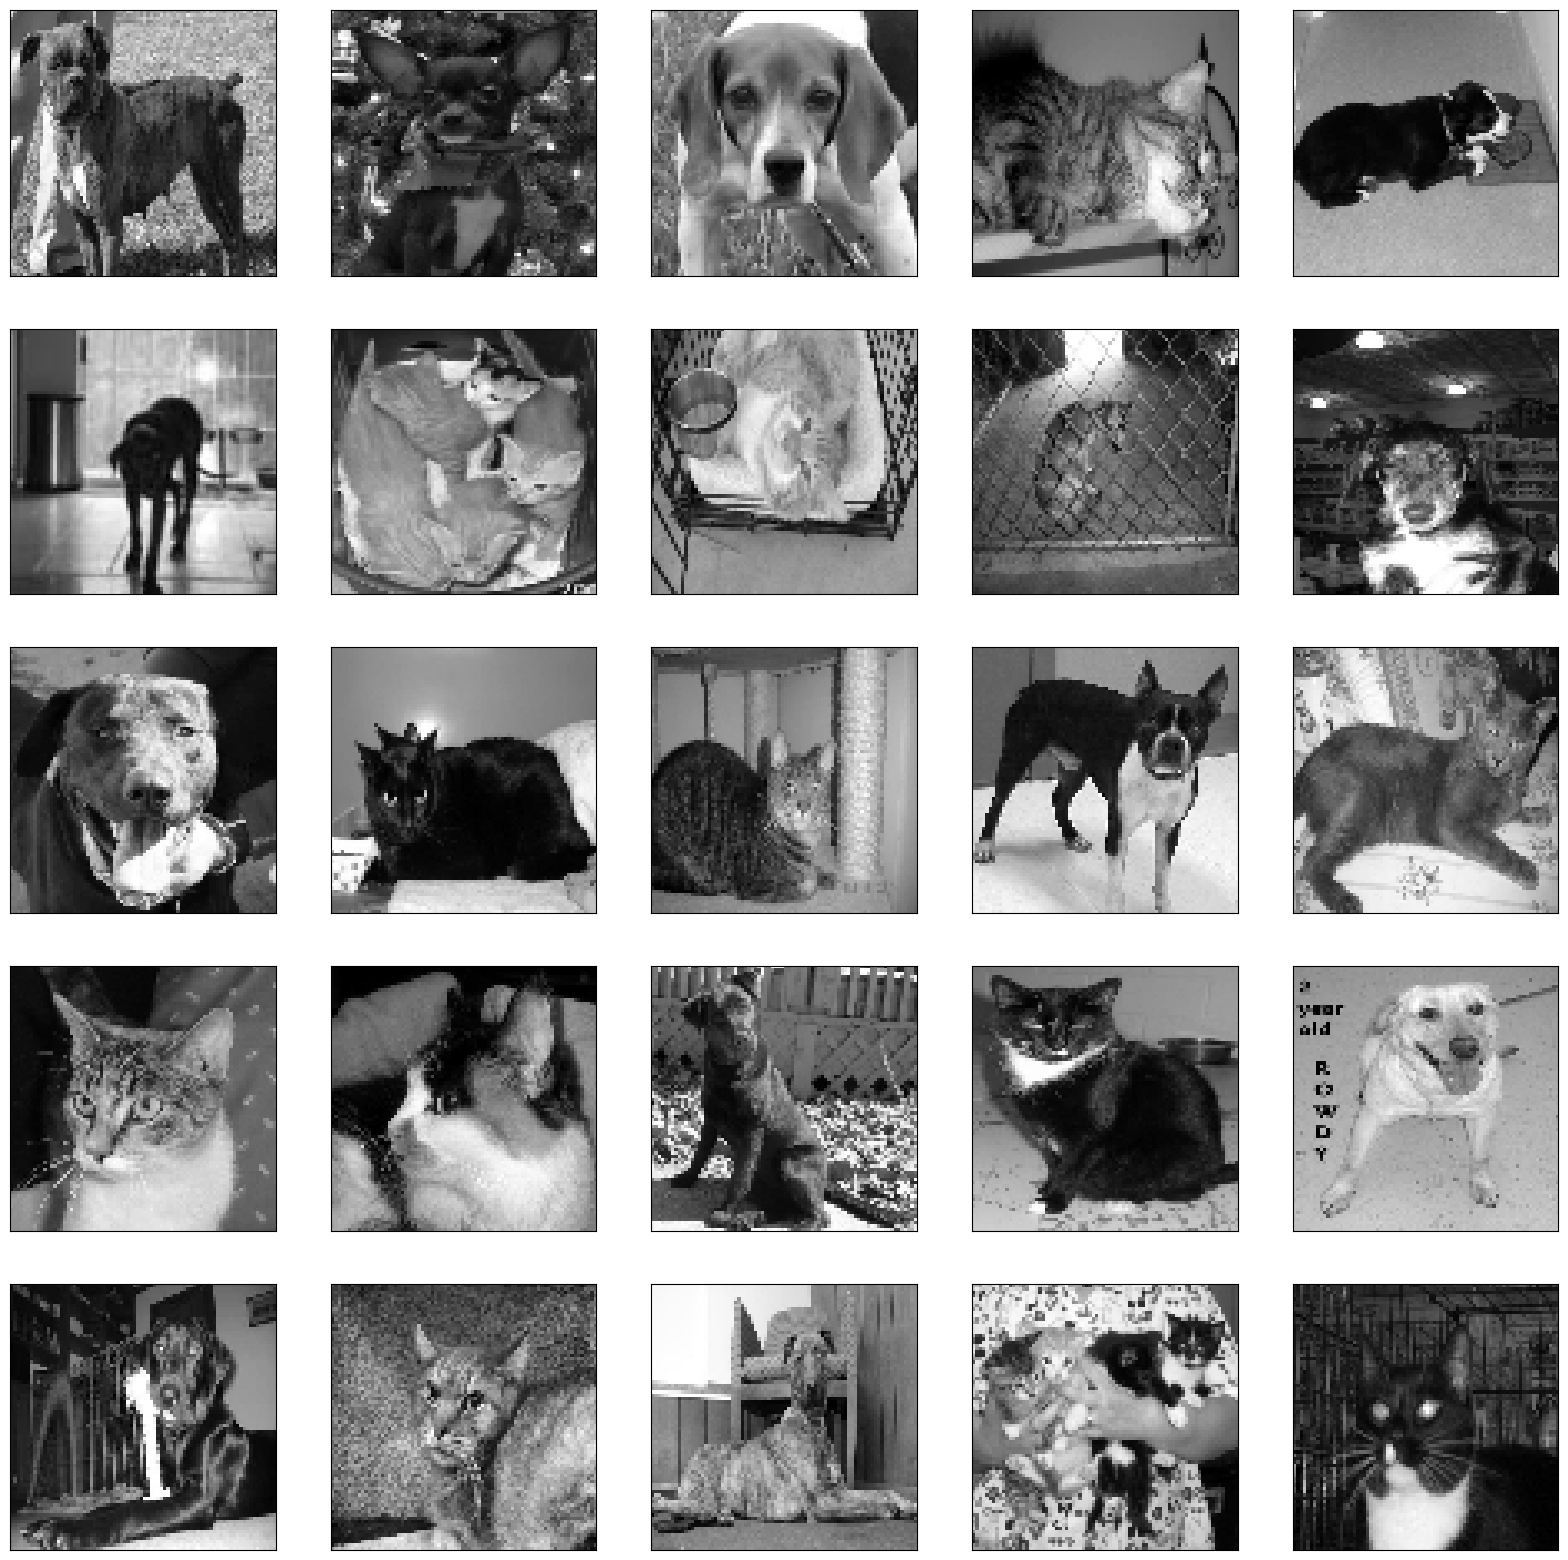

In [4]:
tamaño=80 #Este será el tamaño de la imagen con el que se va a entrenar la red. Lo que buscamos es que no sea un numero muy alto porque entonces las imagenes serian mas grandes y por lo tanto más tardado de entrenar.
plt.figure(figsize=(20,20)) #Solo para que se vea más grande
for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (tamaño, tamaño)) #Aquí lo que hago es redimensionar el tamaño de las imagenes a uno para todos
  imagen = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY) #Pasare las imagenes a blanco y negro
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray') #aquí indico que solo usaré un solo canal de color

In [5]:
data_train=[]

In [6]:
for i, (imagen, etiqueta) in enumerate(datos['train']): #Todos los datos
  imagen = cv2.resize(imagen.numpy(), (tamaño, tamaño))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(tamaño, tamaño, 1) #Cambiar tamano a 80,80,1
  data_train.append([imagen, etiqueta])

In [7]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in data_train:
  X.append(imagen)
  y.append(etiqueta)

In [8]:
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
import numpy as np
X = np.array(X).astype(float) / 255
y = np.array(y)


In [33]:
!pip install wandb -qU


In [34]:

import wandb

In [37]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [38]:

wandb.init(project='Dogs&Cats', entity='dogs-cats')


In [41]:
from wandb.keras import WandbCallback


In [50]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from wandb.keras import WandbCallback
import time
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard

# Definir el modelo
modeloCNN2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(80, 80, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo antes de entrenarlo
modeloCNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Configurar TensorBoard
tensorboardCNN2 = TensorBoard(log_dir='logs/cnn2')

# Cargar tus datos (X, y) aquí
# ...

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Configurar el generador de datos para entrenamiento con aumentación de datos
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Configurar el generador de datos para validación (sin aumentación de datos)
datagen_val = ImageDataGenerator()

# Entrenar el modelo y guardar el historial de entrenamiento
historial_entrenamiento = modeloCNN2.fit(
    datagen_train.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,  # Número de lotes por época
    epochs=100,
    validation_data=datagen_val.flow(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) / 32,  # Número de lotes de validación por época
    callbacks=[tensorboardCNN2, WandbCallback()]
)

# Guardar el modelo
modeloCNN2.save('modelo_perros_gatos.h5')
print("Modelo y historial de entrenamiento guardados correctamente.")

# Guardar el historial de entrenamiento en un archivo CSV
historial_df = pd.DataFrame(historial_entrenamiento.history)
historial_df.to_csv('historial_entrenamiento.csv', index=False)

print("Tiempo de entrenamiento: {:.2f} segundos".format(tiempo_entrenamiento))

# Calcular la precisión en el conjunto de entrenamiento
precision = modeloCNN2.evaluate(X, y)[1]
print("Precisión en el conjunto de entrenamiento:", precision)

Epoch 1/100
617/617 [==============================] - 21s 31ms/step - loss: 0.7850 - accuracy: 0.5247 - val_loss: 0.6895 - val_accuracy: 0.5510
Epoch 2/100
617/617 [==============================] - 20s 33ms/step - loss: 0.6887 - accuracy: 0.5622 - val_loss: 0.6878 - val_accuracy: 0.5510
Epoch 3/100
617/617 [==============================] - 20s 32ms/step - loss: 0.6794 - accuracy: 0.5948 - val_loss: 0.6722 - val_accuracy: 0.6003
Epoch 4/100
617/617 [==============================] - 20s 32ms/step - loss: 0.6703 - accuracy: 0.6142 - val_loss: 0.6900 - val_accuracy: 0.5768
Epoch 5/100
617/617 [==============================] - 21s 34ms/step - loss: 0.6599 - accuracy: 0.6353 - val_loss: 0.6283 - val_accuracy: 0.6685
Epoch 6/100
617/617 [==============================] - 21s 34ms/step - loss: 0.6531 - accuracy: 0.6440 - val_loss: 0.6320 - val_accuracy: 0.6542
Epoch 7/100
617/617 [==============================] - 22s 35ms/step - loss: 0.6469 - accuracy: 0.6473 - val_loss: 0.6173 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


727/727 [==============================] - 4s 5ms/step - loss: 0.4811 - accuracy: 0.7931
Precisión en el conjunto de entrenamiento: 0.7930960655212402


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

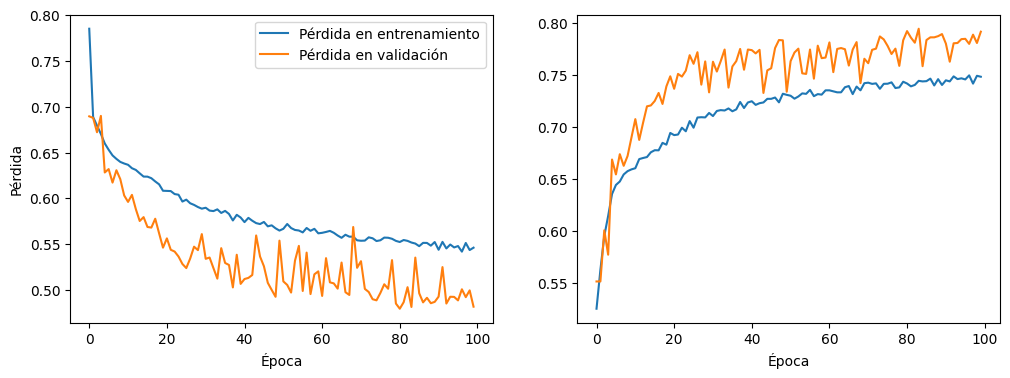

In [51]:
import matplotlib.pyplot as plt

# Cargar el historial de entrenamiento desde el archivo CSV
historial_df = pd.read_csv('historial_entrenamiento.csv')

# Visualizar las métricas de pérdida en el conjunto de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historial_df['loss'], label='Pérdida en entrenamiento')
plt.plot(historial_df['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Visualizar las métricas de precisión en el conjunto de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(historial_df['accuracy'], label='Precisión en entrenamiento')
plt.plot(historial_df['val_accuracy'], label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel
